# Bayesian constraint based on Renoult et al. (2020)
A Bayesian framework for emergent constraints: case studies of climate sensitivity with PMIP

manuscript: https://cp.copernicus.org/articles/16/1715/2020/cp-16-1715-2020.html

based on provided script by authors: https://git.bolin.su.se/bolin/renoult-2020/-/blob/master/Bayesian_for_LGM_PMIP.py

saves prior_post.csv for Fig 3

In [178]:
## Library
from pymc3 import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import scipy.stats as stat
from scipy.optimize import curve_fit
import xarray as xr
from adjustText import adjust_text
import pandas as pd
import seaborn as sns
from numpy.random import normal,uniform

# functions

def load_data(regime='unstable'):
    '''
    Load relevant data
    
    Output
    ---
    x           abrupt-4xCO2 feedback
    y           piControl feedback
    y0          CERES feedback
    y0_err      CERES feedback standard error
    '''

    if regime != 'full':
        sw_y,lw_y,net_y = np.load('I:/ubuntu_files/sam/Documents/CIRCULATES/data/cmip_pi_feeds_binnedpi_2lims_5585_mask_compare_Tfull.npy')[:,:,0]
        sw_x,lw_x,net_x = np.load('I:/ubuntu_files/sam/Documents/CIRCULATES/data/cmip_4xco2_feeds_binned4x_2lims_5585_mask_compare_Tfull.npy')[:,:,0]
        ds = xr.load_dataset('I:/ubuntu_files/sam/Documents/CIRCULATES/data/obs_pi_feeds_2lims_5585_mask_compare_Tfull.nc')
    else:
        sw_y,lw_y,net_y = np.load('I:/ubuntu_files/sam/Documents/CIRCULATES/data/cmip_pi_feeds_binnedpi_full_5585_mask_compare_Tfull.npy')
        sw_x,lw_x,net_x = np.load('I:/ubuntu_files/sam/Documents/CIRCULATES/data/cmip_4xco2_feeds_binned4x_full_5585_mask_compare_Tfull.npy')
        ds = xr.load_dataset('I:/ubuntu_files/sam/Documents/CIRCULATES/data/obs_pi_feeds_full_mask_compare_Tfull.nc')

    prop = {
        'stable':0.205,
        'mid':0.112,
        'unstable':0.056,
        'full':0.205+0.112+0.056
    }[regime]
    
    if regime!='full':
        y0 = prop*ds.net_feed.sel(obs_type='era5',regime=regime).values
        y0_err = prop*ds.net_se.sel(obs_type='era5',regime=regime).values
        #y0_ncep = prop*ds.net_feed.sel(obs_type='ncep',regime=regime).values
        #y0_err_ncep = prop*ds.net_se.sel(obs_type='ncep',regime=regime).values
        i = ['stable','mid','unstable'].index(regime)
        x = prop*net_x[:,i]
        y = prop*net_y[:,i]
    else:
        y0 = prop*ds.net_feed.values
        y0_err = prop*ds.net_se.values
        x = prop*net_x
        y = prop*net_y

    return x,y,y0,y0_err

def BLR(x,y):
    '''
    estimating linear relationship between x and y using bayes linear regression
    '''

    with Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
        # Define prior means, sd
        
        mn_intercept = 0.0
        mn_slope = 1.0
        sd_reg = 1.0
            
        # Define priors for parameters:
        
        sigma = HalfCauchy('Sigma', beta=5, testval=1.)
        intercept = Normal('Intercept', mn_intercept, sd=sd_reg)
        x_coeff = Normal('x', mn_slope, sd=sd_reg)

        # Define likelihood
        
        likelihood = Normal('y', mu=intercept + x_coeff * x, 
                            sd=sigma, observed=y)
        
        # Inference! 4 jobs in parallel (convergence check)
        # By default, the sampling method is NUTS
        
        trace = sample(progressbar=True, draws=100000, cores=4, tune=5000)


    # Extract the data of the trace
    values_x = trace['x']
    values_intercept = trace['Intercept']
    values_sigma = trace['Sigma']

    return values_x, values_intercept, values_sigma


def gen_mod(alpha, x, beta, error):
    '''
    Model to generate a single point based on the prior on x
    '''
    return alpha * x + beta + np.random.normal(loc=0, scale=error)

def likelihood(sim, obs, std):
    '''
    Likelihood estimate  
    '''
    return stat.norm.pdf(x=sim, loc=obs, scale=std)

def bayesian_updating(x,y0,y0_err,values_x,values_intercept,values_sigma,prior_dist="normal",uni_range=[-.5,.5],norm_scale=1):
    '''
    Bayesian updating given the relationship parameters (values_x, values_intercept, values_sigma)
    x,y,y0_err and the prior type and parameters

    prior_dists:            "normal", "generic_norm" or "uniform"
    uni_range:              range for uniform prior distribution
    norm_scale:              scale for normal prior distribution
    '''

    if prior_dist=="normal":
        prior_x = normal(loc=np.mean(x), scale=norm_scale*np.std(x), size=400000)
    elif prior_dist=="generic_norm":
        prior_x = normal(loc=0, scale=norm_scale*1, size=400000)
    elif prior_dist=="uniform":
        prior_x = uniform(uni_range[0],uni_range[1], size=400000)
    else:
        print('Input correct prior_dist; must be one of "normal", "generic_norm" or "uniform"')
        return

    # Generate predicted piControl values from abrupt-4xCO2 prior and linear relationship
    model_y = gen_mod(values_x, prior_x, values_intercept, values_sigma)

    # Create weights through importance sampling
    weight = likelihood(model_y, y0, y0_err)
    weight = weight/weight.sum()

    # Bayesian updating of the prior with importance sampling weight
    posterior = np.random.choice(prior_x, size=400000, p=weight)

    # observation normal distribution
    gauss_obs = np.random.normal(loc=y0, scale=y0_err, size=800000)

    return prior_x, posterior, gauss_obs

def plot_prior_post(prior_x,posterior,regime,prior_dist="normal",uni_range=[-.5,.5],norm_scale=.2,prior_stats=(0,1),ax=None,legend=True):
    '''
    plot prior and posterior pdfs
    '''

    post_mean,post_std = np.mean(posterior),np.std(posterior)
    #prior_mean,prior_std = np.mean(prior_x),np.std(prior_x)
    prior_mean,prior_std = prior_stats

    # Compute 5-95% prior posterior intervals 
    post_stats_90 = np.percentile(posterior, q=(5, 95))
    #prior_stats_90 = np.percentile(prior_x, q=(5, 95))
    prior_stats_90 = [prior_mean - 1.645*prior_std, prior_mean + 1.645*prior_std]

    if prior_dist=="normal":
        xlims = {'stable':[-.4,.4],
                'mid':[-.3,.3],
                'unstable':[-norm_scale,norm_scale],
                'full':[-.5,.5]
        }[regime]
    else:
        xlims = {'stable':[-.4,.4],
                'mid':[-.3,.3],
                'unstable':uni_range,
                'full':[-.5,.5]
        }[regime]

    #plotting
    print(xlims)
    x1=np.linspace(xlims[0],xlims[1],100)
    sns.set_style("whitegrid")
    
    if ax is None:
        fig,ax = plt.subplots(figsize=[10,7])

    if prior_dist=="normal":
        prior_y = stat.norm.pdf(x1,prior_mean,prior_std)
    else:
        prior_y = stat.uniform.pdf(x1,uni_range[0],np.diff(uni_range))
        
    sns.lineplot(x=x1,y=prior_y,ax=ax,label=f"prior; mean: {prior_mean:.3f}, std: {prior_std:.3f}\npred: {prior_stats_90[0]:.3f} - {prior_stats_90[1]:.3f}")
    ax.fill_between(x=x1,y1=np.zeros(np.shape(x1)),y2=prior_y,where=np.logical_and(prior_stats_90[0]<x1,x1<prior_stats_90[1]),color=(1,1,1,0),hatch='//',ec=(0,0,1,0.5))

    post_y = stat.norm.pdf(x1,post_mean,post_std)
    sns.lineplot(x=x1,y=post_y,ax=ax,label=f"posterior; mean: {post_mean:.3f}, std: {post_std:.3f}\npred: {post_stats_90[0]:.3f} - {post_stats_90[1]:.3f}")
    ax.fill_between(x=x1,y1=np.zeros(np.shape(x1)),y2=post_y,where=np.logical_and(post_stats_90[0]<x1,x1<post_stats_90[1]),color=(1,1,1,0),hatch="\\\\",ec=(255/255., 127/255., 14/255.,.7))

    ylims = np.array(ax.get_ylim())
    ylims[1] = ylims[1]+np.diff(ylims)[0]*.25
    ax.set_ylim([0,ylims[1]])

    err1 = ax.errorbar(x=0,y=ax.get_ylim()[0]-.07*np.diff(ax.get_ylim()),xerr=0.37,capsize=5,capthick=1,clip_on=False,alpha=.5)#,label='Sherwood et. al (2020)')
    err2 = ax.errorbar(x=0.17,y=ax.get_ylim()[0]-.1*np.diff(ax.get_ylim()),xerr=0.19,capsize=5,capthick=1,clip_on=False,alpha=.5)#,label='Ceppi et. al (2022)')
    err3 = ax.errorbar(x=0.07,y=ax.get_ylim()[0]-.13*np.diff(ax.get_ylim()),xerr=0.38,capsize=5,capthick=1,clip_on=False,alpha=.5)#,label='Ceppi et. al (2022)')
    
    legend1 = ax.legend(loc='upper left',title='PDFs')
    ax.add_artist(legend1)

    import matplotlib.lines as mlines
    err1_line = mlines.Line2D([], [], color=err1.get_children()[0].get_color(), label='Sherwood et. al (2020)',alpha=.5)
    err2_line = mlines.Line2D([], [], color=err2.get_children()[0].get_color(), label='Ceppi et. al (2022)',alpha=.5)
    err3_line = mlines.Line2D([], [], color=err3.get_children()[0].get_color(), label='AR6',alpha=.5)
    
    if legend:
        ax.legend(handles=[err1_line,err2_line,err3_line],title='Previous Study bars')

    #ax.tick_params(axis='x',pad=10)
    #legend1 = ax.legend(loc='upper left')
    
    ax.set_ylabel('Probability Density')
    ax.set_xlabel(r'Wm$^{-2}$K$^{-1}$',labelpad=24)
    
    ax.set_xlim(xlims)
    ax.set_title('')
    return(err1)

def plot_post_compare(posteriors,regime,uni_range=[-.5,.5],labs=['CMIP6 prior','Uniform (-.5,.5)']):
    '''
    Plot to compare multiple posterior pdfs
    '''

    post_means,post_stds=np.transpose(list(map(lambda x: [np.mean(x),np.std(x)],posteriors)))

    # Compute 5-95% and 17-83% posterior intervals 
    post_stats_90s = list(map(lambda x: np.percentile(x, q=(5, 95)),posteriors))

    
    xlims = {'stable':[-.4,.4],
            'mid':[-.3,.3],
            'unstable':[-.2,.5],
            'full':[-.5,.5]
    }[regime]

    x1=np.linspace(xlims[0],xlims[1],100)
    sns.set_style("whitegrid")
    fig,ax = plt.subplots(figsize=[10,7])
    
    for post_mean,post_std,post_stats_90,lab in zip(post_means,post_stds,post_stats_90s,labs):
        post_y = stat.norm.pdf(x1,post_mean,post_std)
        sns.lineplot(x=x1,y=post_y,ax=ax,label=f"{lab}; mean: {post_mean:.3f}, std: {post_std:.3f}\npred: {post_stats_90[0]:.3f} - {post_stats_90[1]:.3f}")
        ax.fill_between(x=x1,y1=np.zeros(np.shape(x1)),y2=post_y,where=np.logical_and(post_stats_90[0]<x1,x1<post_stats_90[1]),alpha=.3)

    ax.legend(loc='upper left')
    ax.set_ylabel('Probability Density')
    ax.set_xlabel(r'Wm$^{-2}$K$^{-1}$')
    ylims = np.array(ax.get_ylim())
    ylims[1] = ylims[1]+np.diff(ylims)[0]*.25
    ax.set_ylim([0,ylims[1]])
    
    ax.set_title('')


# Calculating posterior for unstable regime using cmip6-based prior

In [2]:
x,y,y0,y0_err = load_data(regime='unstable')
values_x, values_intercept, values_sigma = BLR(x,y)

prior_x, posterior,gauss_obs = bayesian_updating(x,y0,y0_err,values_x,values_intercept,values_sigma,prior_dist="normal")
print(np.mean(gauss_obs),np.std(gauss_obs))

C:\Users\Sam\AppData\Local\Temp\ipykernel_15508\1698101243.py:87: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = sample(progressbar=True, draws=100000, cores=4, tune=5000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept, Sigma]


Sampling 4 chains for 5_000 tune and 100_000 draw iterations (20_000 + 400_000 draws total) took 213 seconds.


-0.020729751452335674 0.0196332041373093


In [3]:
#mean and sd of posterior
(np.mean(posterior),np.std(posterior))

(0.016707819670467097, 0.04670201665397359)

In [4]:
#mean and sd of piControl
(np.mean(y),np.std(y))

(-0.10035014682274626, 0.1201920010642799)

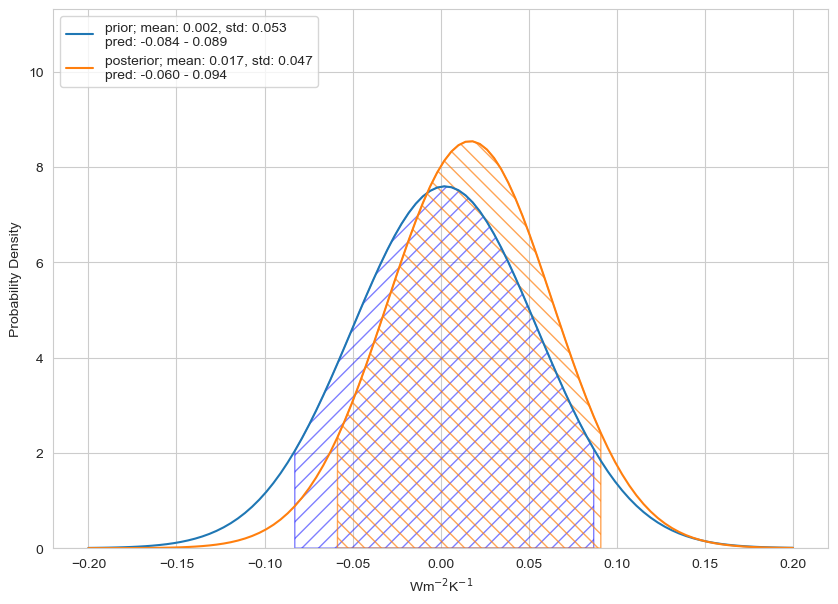

In [5]:
#plotting prior and posterior
plot_prior_post(prior_x,posterior,'unstable',prior_dist="normal")

In [82]:

prior_x2, posterior2,gauss_obs = bayesian_updating(x,y0,y0_err,values_x,values_intercept,values_sigma,prior_dist="generic_norm",norm_scale=.5)
print(np.mean(gauss_obs),np.std(gauss_obs))

C:\Users\Sam\AppData\Local\Temp\ipykernel_21124\2814036410.py:88: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = sample(progressbar=True, draws=100000, cores=4, tune=5000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept, Sigma]


Sampling 4 chains for 5_000 tune and 100_000 draw iterations (20_000 + 400_000 draws total) took 213 seconds.


-0.020775438948997995 0.019626665526585554


[-0.4, 0.4]
[-1, 1]


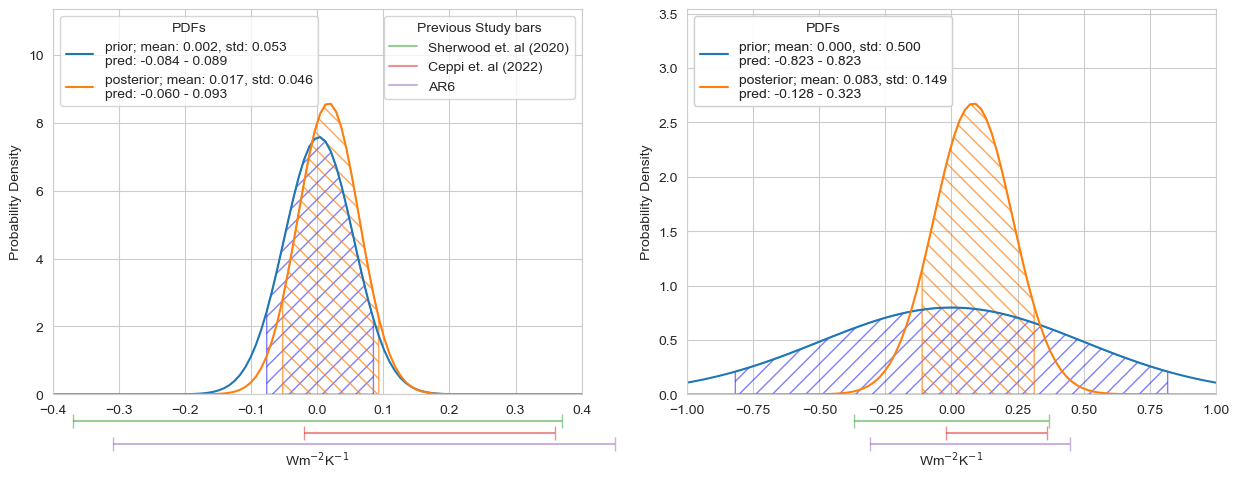

In [179]:
fig,axs = plt.subplots(ncols=2,figsize=[15,5])

err = plot_prior_post(prior_x,posterior,'unstable',prior_dist="normal",norm_scale=.4,prior_stats=(np.mean(x),np.std(x)),ax=axs[0])
plot_prior_post(prior_x2,posterior2,'unstable',prior_dist="normal",norm_scale=1,prior_stats=(0,0.5),ax=axs[1],legend=False)


-0.36299095451814367
-0.3076050466404038


Text(0, 0.5, 'Wm$^{-2}$K$^{-1}$')

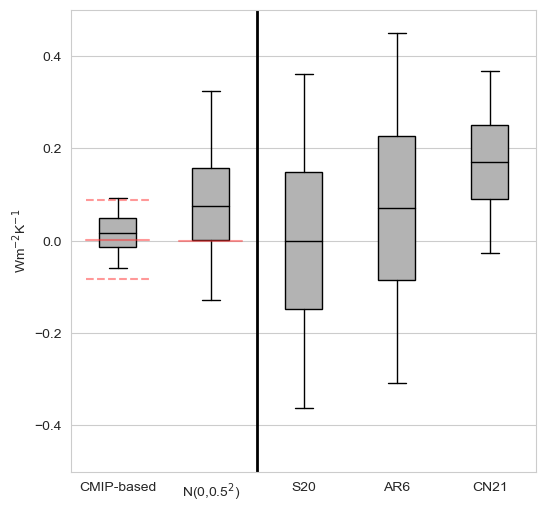

In [214]:
fig,ax = plt.subplots(figsize=[6,6])

sher_norm = np.random.normal(0,0.22,400000)
ar6_norm = np.random.normal(0.07,0.23,400000)
ceppi_norm = np.random.normal(0.17,0.12,400000)
print(np.percentile(sher_norm,5))
print(np.percentile(ar6_norm,5))

df = pd.DataFrame({'CMIP-based prior':prior_x,
    'Generic normal prior':prior_x2,
    'CMIP-based posterior':posterior,
    'Generic normal posterior':posterior2,
    'Sherwood':sher_norm,
    'AR6':ar6_norm,
    'Ceppi': ceppi_norm}
    )

#save for Fig3
df.to_csv("./output/prior_post.csv")

props = {'color':'black'}
bplot=df[['CMIP-based posterior','Generic normal posterior','Sherwood','AR6','Ceppi']].plot.box(whis=[5,95],showfliers=False,ax=ax,widths=.4,
    boxprops={'color':'black','facecolor':'.7'},medianprops=props,whiskerprops=props,capprops=props,patch_artist=True)


ax.axhline(y=np.median(prior_x),xmin=0.16*0.2,xmax=0.84*.2,color=(1,0.2,0.2),alpha=.5)
ax.axhline(y=np.percentile(prior_x,5),xmin=0.16*0.2,xmax=0.84*.2,color=(1,0.2,0.2),linestyle='dashed',alpha=.5)
ax.axhline(y=np.percentile(prior_x,95),xmin=0.16*0.2,xmax=0.84*.2,color=(1,0.2,0.2),linestyle='dashed',alpha=.5)
ax.axhline(y=0,xmin=0.2+0.16*.2,xmax=0.2+0.84*.2,color=(1,0.2,0.2),alpha=.5)

ax.axvline(x=2.5,linewidth=2,color='k')
ax.set_ylim([-.5,.5])
ax.grid(axis='x')
ax.set_xticklabels([r'CMIP-based',r'N(0,0.5$^2$)','S20','AR6','CN21'])

ax.get_xlim()
ax.set_ylabel(r'Wm$^{-2}$K$^{-1}$')

